In [9]:
import numpy as np
import scipy.optimize as opt
from scipy.integrate import quad
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
class pr_eos():
    '''Peng-Robinson Cubic
    Equation of State class'''
    def __init__(self,fluid,T):
        '''Instatiates fluid and
        temperature'''
        self.fluid = fluid
        self.T = T
    
    def pr_coefs(self):
        '''Calculates fluid critical
        properties and PR coefficient'''
        M = CP.PropsSI('molarmass',self.fluid)
        Tc = CP.PropsSI('Tcrit',self.fluid)
        pc = CP.PropsSI('Pcrit',self.fluid)        
        omega = CP.PropsSI('acentric',self.fluid)
        self.b = 0.07780 * (R/M) * Tc / pc
        alpha = 1 + (0.37464 + 1.54226 * omega - \
                0.26992 * omega**2) * (1 - np.sqrt(self.T / Tc))
        self.a = 0.45724 *( (R * Tc/M) ** 2) * alpha ** 2 / pc   
        self.M = M
        return(self.a,self.b,self.M,self.T)    
    
    def p_sat(self,guess):
        '''Solves for the saturation pressure
        via the Maxwell equal area rule'''
        p_sat = opt.fsolve(maxwell,guess)
        return(p_sat)

    
def vols(p_guess):
    '''Solves the PR equation in the
    cubic dimensionless form'''
    a,b,M,T = pr.pr_coefs()
    Rw = R/M
    p = p_guess
    A_mult = p / (Rw * T) ** 2
    B_mult = p / (Rw * T)
    a3 = 1
    a2 = 1 - B_mult*b
    a1 = A_mult * a - 3 * (B_mult * b) ** 2\
                                   - 2 * B_mult * b
    a0 = A_mult * a * B_mult * b -(B_mult * b) ** 2\
                                - (B_mult * b) ** 3
    coeff = [a3,-a2,a1,-a0]
    vol = np.roots(coeff) * Rw * T / p_guess
    v_l, v_v = np.min(vol), np.max(vol)
    return(v_l, v_v,a,b,M,T)

def maxwell(guess):
    '''Calculates Maxwell equal area rule'''
    v_l, v_v, a, b, M, T = vols(guess)
    integ = quad(lambda v: ((R/M) * T / (v - b)
                        - a / (v**2 + 2*v*b - b**2)),v_l,v_v,epsabs=0)
    return(integ[0] - guess*(v_v - v_l))

C:\Users\Júlio\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:357: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
C:\Users\Júlio\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:357: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
C:\Users\Júlio\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:357: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  under

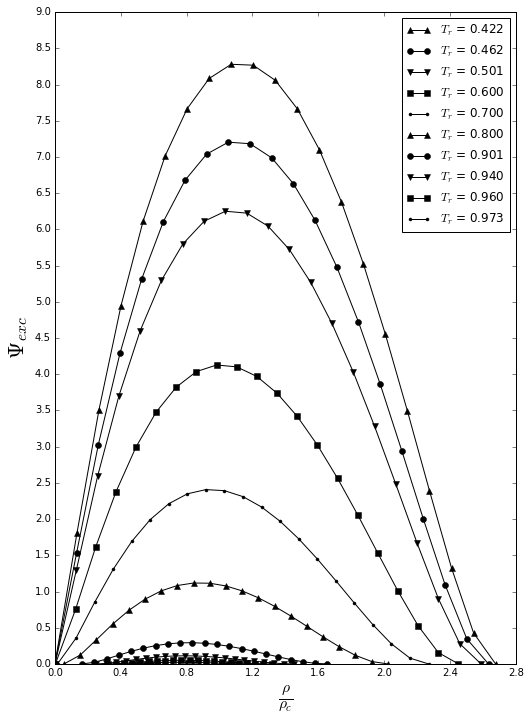

In [225]:
R = 8.314
Tr = [0.4220,0.4622,0.5008,0.5997,0.7001,0.8005,
      0.9009,0.9395,0.9596,0.973]
rhoc = CP.PropsSI('rhocrit','water')
pc = CP.PropsSI('pcrit','water')
Tc = CP.PropsSI('Tcrit','water')
psat = 101325
fig1,ax1 = plt.subplots(ncols=1,figsize=(8.26,11.68))
lines = ['-k^','-ko','-kv','-ks','-k.','-k^','-ko','-kv','-ks','-k.']
psis = {}
for i,tr in enumerate(Tr):
    temp = tr * Tc
    pr = pr_eos('water',temp)
    psat = pr.p_sat(psat)
    v_l,v_v,a,b,M,T = vols(psat)    
    rho_range = np.linspace(1/v_l,1/v_v,21)
    psi = []
    for k in rho_range:
        psi.append(k*quad(lambda rho: (rho*(R/M)*T/(1 - rho*b) -
                a * rho**2 /(1 + 2 * rho * b - (rho * b)**2 ))/
                          rho**2 - psat/rho**2,rho_range[0],k)[0])
    psi = np.array(psi)
    psis[tr] = psi
    ax1.plot(rho_range / rhoc, psi / pc, 
             lines[i], label = r'$T_r$ = %0.3f' %Tr[i])
ax1.legend(loc='upper right')
ax1.set_ylabel(r'$\Psi_{exc}$',fontsize=22)
ax1.set_xlabel(r'$\frac{\rho}{\rho_c}$',fontsize=22)
ax1.set_xticks(np.linspace(0,2.8,8));
ax1.set_yticks(np.linspace(0,9,19));
ax1.set_xlim([0,2.8]);
ax1.set_ylim([0,9]);

In [226]:
Tr = np.array([0.5,0.6,0.7])
psat = 101325
for i, tr in enumerate(Tr):
    temp = tr * Tc
    pr = pr_eos('water',temp)
    psat = pr.p_sat(psat)
    v_l,v_v,a,b,M,T = vols(psat)    
    rho_range = np.linspace(1/v_l,1/v_v,21)
    rhor = rho_range/rhoc
    #I = []
    psi = []
    for k in rho_range:
        psi.append(k*quad(lambda rho: (rho*(R/M)*T/(1 - rho*b) -
                a * rho**2 /(1 + 2 * rho * b - (rho * b)**2 ))/
                          rho**2 - psat/rho**2,rho_range[0],k)[0])
    psi = np.array(psi)
    I = [np.sqrt(x/pc) if x > 0 else 0 for x in psi]
    I = np.trapz(I,x=np.flipud(rhor))
    kappa = (CP.PropsSI('I','T',temp,'Q',0,'water') / (rhoc * I * np.sqrt(2*pc)))**2
    print(kappa)

4.51193595267e-17
5.35728622123e-17
6.32356772614e-17


C:\Users\Júlio\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:357: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
C:\Users\Júlio\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:357: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
